# This notebook if for analysing/deriving the following:
    1. Processing RC data from PB14 and E18
    2. Mass model RC of MW using Ultranest  
    3. Compare Exponential vs Plummer models for the Bulge  
    4. Study the LSR dependence of PB14 data   
    5. Study 2 disc to 1 disc approximation  
    6. Obain VDF of MW at $R_\odot$ (gal frame and Earth frame)

All the results of these analysis are stored in '../Output/MW_dict.pkl'

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import ultranest
import ultranest.stepsampler as ultrastep
import pickle
import sys,os,json
sys.path.append('../../')
import project.profiles as pp
from project.tools.constants import Constants as pc

# 1. Processing RC data from PB14 and E18

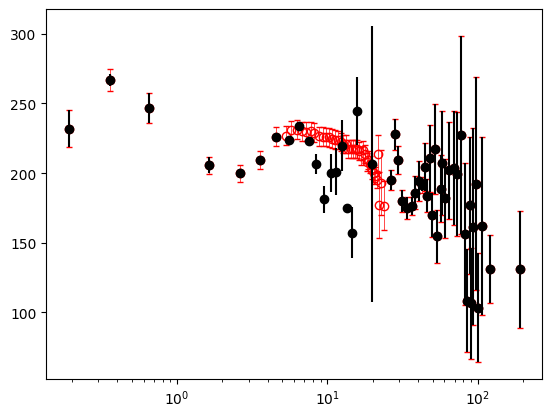

In [4]:
plt.errorbar(mw_r1, mw_v1, mw_e1, fmt='o', c='k')
plt.errorbar(mw_r, mw_v, mw_e, c = 'None', ecolor = clr, capsize = 2, elinewidth = 0.5, fmt = 'o', 
                alpha = 1,mec = clr,zorder = 0)
plt.xscale('log')

E18 range: 5.27 < r/kpc < 24.82


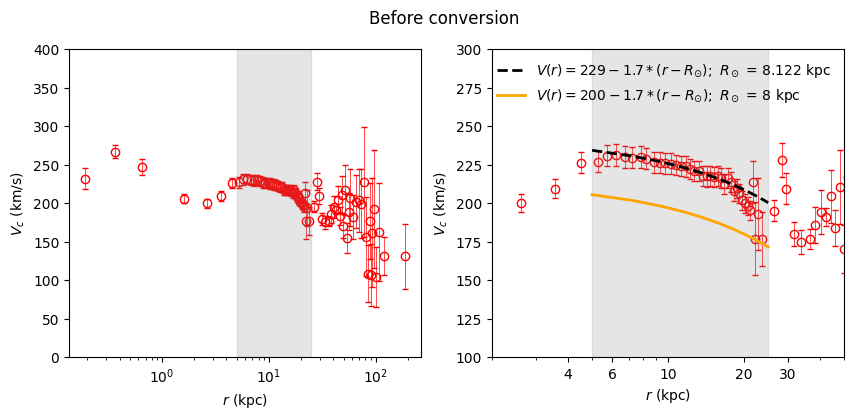

In [2]:
# Importing MW RC data (Eilers + PB, provided by Aakash (IMPRS))
# RC data of MW compiled from  PB 2014 (0 < r < 5 and 25 < r < 220 kpc) and Eilers 2018 (5 < r < 25 kpc)
#(../../Accessory/mw1.dat) and #Eilers(../../Accessory/mw2.dat).

mw1 = np.loadtxt('../../Accessory/mw1.dat')
mw2 = np.loadtxt('../../Accessory/mw2.dat')
indx = np.where(mw1[:,0] == 8.0) # Assuming Rsun = 8kpc and Vsun = 200 km/s for obtaining the data from PB 2014.

mw_r1 = mw1[:,2][indx]
mw_v1 = mw1[:,3][indx]
mw_e1 = mw1[:,4][indx]
mw_r2 = mw2[:,0]
mw_v2 = mw2[:,1]
mw_e2 = np.mean((mw2[:,2],mw2[:,3]),axis = 0)

r_start = mw_r2[0]
r_stop = mw_r2[-2]
print (f'E18 range: {r_start} < r/kpc < {r_stop}')

# A first order approximation to the 
Δc = (229.0 - 1.7*8.122) - (200.0 - 1.7*8.0)
mw_v2_ = mw_v2 - Δc
mw_e2_ = (mw_e2/mw_v2)*mw_v2_
mw_r2_ = mw_r2

title, clr = 'Before conversion', 'r'
# Uncomment the below if the conversion has to applied
# mw_v2,mw_e2,mw_r2 = mw_v2_,mw_e2_,mw_r2_
# title, clr = 'After conversion', 'g'


mw_r = np.concatenate((mw_r1[mw_r1 < r_start],mw_r2[:-2],mw_r1[mw_r1 > r_stop]))
mw_v = np.concatenate((mw_v1[mw_r1 < r_start],mw_v2[:-2],mw_v1[mw_r1 > r_stop]))
mw_e = np.concatenate((mw_e1[mw_r1 < r_start],mw_e2[:-2],mw_e1[mw_r1 > r_stop]))

argsort = np.argsort(mw_r)
mw_r = mw_r[argsort]
mw_v = mw_v[argsort]
mw_e = mw_e[argsort]

mw_e[mw_e/mw_v < 0.03] = 0.03*mw_v[mw_e/mw_v < 0.03]

mw_w = mw_v/mw_r
mw_we = mw_w*(mw_e/mw_v)

fig,axs = plt.subplots(1,2,figsize = (10,4))
ax1,ax2 = axs

for ax in axs:

    ax.errorbar(mw_r, mw_v, mw_e, c = 'None', ecolor = clr, capsize = 2, elinewidth = 0.5, fmt = 'o', 
                alpha = 1,mec = clr,zorder = 0)

    ax.set_xscale('log')
    ax.set_ylim(0,400)
    ax.set_xlabel('$r$ (kpc)')
    ax.set_ylabel('$V_c$ (km/s)')

    ylim = ax.get_ylim()
    ax.fill_betweenx(ylim,5,25,color = 'grey',alpha = 0.2)

r = np.linspace(5,25,10)
vc = 229.0 - 1.7*(r - 8.122)
ax2.plot(r,vc, c = 'k',ls = '--',zorder = 2,lw = 2,label = '$V(r) = 229 - 1.7*(r - R_{\odot});$ $R_\odot$ = 8.122 kpc')

ax2.plot(r,vc-Δc, c = 'orange',ls = '-',zorder = 2, lw = 2,label = '$V(r) = 200 - 1.7*(r - R_{\odot});$ $R_\odot$ = 8 kpc')
ax2.legend(framealpha = 0)

ax2.set_xlim(2,50)
ax2.set_xticks([4,6,10,20,30],)
ax2.set_xticklabels(['4','6','10','20','30'])
ax2.set_ylim(100,300)

plt.suptitle(title);
# plt.savefig('../Output/figures/MW_RC_{title}.png',bbox_inches = 'tight',dpi = 300)

In [5]:
MW_dict = pickle.load(open('../../Output/MW_dict.pkl','rb'))
# MW_dict['PBRC'] = np.array([mw_r1, mw_v1, mw_e1]).T
# pickle.dump(MW_dict, open('../../Output/MW_dict.pkl','wb'))

# 2. Mass model RC of MW using Ultranest

In [4]:
MW_dict = pickle.load(open('../../Output/MW_dict.pkl','rb'))
mwd = MW_dict.copy()

In [5]:
mw_RC = MW_dict['PBRC']
mw_r, mw_v, mw_e = mw_RC[:,0], mw_RC[:,1], mw_RC[:,2]

def v_plummer(logM, b, r):
    M = 10**logM
    Mr = M*(r**3/(b**2 + r**2)**(3/2))
    return np.sqrt(pc.G*Mr/r)
    
def RCmodel(params,output = 'model',r = mw_r, bulge = 'EXP'):
    m200,c200,mdstar,mdbul,mdgas,rdstar,rdbul,rdgas = params
    rs = pp.rs_nfw(np.log10(m200)+12., c200)
    vnfw = pp.v_nfw(np.log10(m200)+12., rs, r)
    vdstar = pp.v_exp(np.log10(mdstar)+9., rdstar, r)
    vdgas = pp.v_exp(np.log10(mdgas)+9., rdgas, r)
    if bulge == 'EXP':
        vdbul = pp.v_exp(np.log10(mdbul)+9., rdbul, r)
    elif bulge == 'Plummer':
        vdbul = v_plummer(np.log10(mdbul)+9., rdbul, r)
    vmodel = np.sqrt(vnfw**2 + vdgas**2 + vdbul**2 + vdstar**2)
    if output == 'model':
        return vmodel
    elif output == 'all':
        return (vmodel, vnfw, vdstar, vdgas, vdbul)

In [6]:
param_names = list(MW_dict['fiducial_range'].keys())

ranges = [[0.1,5.0],[5.0,21.0],
          [10.0,100.0],[1.0,50.0],[1.0,100.0],
          [2.0,8.0],[0.2,2.0],[2.0, 25.0]]

def prior(cube):
    params = cube.copy()
    for i, key in enumerate(param_names):
        fid = ranges[i]
        params[i] = cube[i]*(fid[1] - fid[0]) + fid[0]
    return params

def llike(params):
    if params[7] < params[5]:
        return -1e38
    if params[6] > params[5]:
        return -1e38
    if (params[2] < params[3]) or (params[2] < params[4]):
        return -1e38
    vmodel = RCmodel(params,bulge='EXP')
    indx = np.where((mw_r >= 0))
    ll = -0.5*(((mw_v[indx] - vmodel[indx])/(mw_e[indx]))**2).sum()
    ll -= ((np.log10(params[1]) - pp.lc200_SR(np.log10(params[0])+12.0))/0.11)**2
    return ll

In [7]:
ultraroot = '../../Output/Ultra/PB_RC_fit'
nsteps = 8*len(param_names)
sampler = ultranest.ReactiveNestedSampler(param_names, llike, prior,
                                          log_dir = ultraroot, 
                                          resume = 'resume')
sampler.stepsampler = ultrastep.RegionSliceSampler(nsteps = nsteps)

In [8]:
result = sampler.run()

[ultranest] Resuming from 12875 stored points
[ultranest] Widening roots to 614 live points (have 400 already) ...
[ultranest] Widening roots to 954 live points (have 614 already) ...


[ultranest] Explored until L=-1e+02  .37 [-110.2134..-110.2130]*| it/evals=12445/2138249 eff=inf% N=400   0 
[ultranest] Likelihood function evaluations: 2138249
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -136.1 +- 0.1993
[ultranest] Effective samples strategy satisfied (ESS = 2850.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 398 minimum live points (dlogz from 0.17 to 0.57, need <0.5)
[ultranest]   logZ error budget: single: 0.24 bs:0.20 tail:0.01 total:0.20 required:<0.50
[ultranest] done iterating.


In [26]:
for i, key in enumerate(MW_dict['fiducial_range'].keys()):
    mean = result['posterior']['mean']
    fid = MW_dict['fiducial_range'][key]
    print (f'----{key}--------')
    print (f'[{fid[0]:.1f}, {mean[i]:.1f},  {fid[1]:.1f}]')

----m200--------
[0.9, 1.1,  1.6]
----c200--------
[9.0, 5.7,  17.0]
----mdstar--------
[42.0, 55.5,  63.0]
----mdbul--------
[8.0, 8.0,  20.0]
----mdgas--------
[1.0, 29.9,  20.0]
----rdstar--------
[2.0, 2.6,  4.0]
----rdbul--------
[1.9, 0.2,  2.0]
----rdgas--------
[5.0, 20.5,  20.0]


In [7]:
for i, key in enumerate(MW_dict['fiducial_range'].keys()):
    mean = result['posterior']['mean']
    fid = MW_dict['fiducial_range'][key]
    print (f'----{key}--------')
    print (f'[{fid[0]:.1f}, {mean[i]:.1f},  {fid[1]:.1f}]')

----m200--------
[0.9, 0.7,  1.6]
----c200--------
[9.0, 9.6,  17.0]
----mdstar--------
[42.0, 48.2,  63.0]
----mdbul--------
[8.0, 8.3,  20.0]
----mdgas--------
[1.0, 39.4,  20.0]
----rdstar--------
[2.0, 2.8,  4.0]
----rdbul--------
[1.9, 0.2,  2.0]
----rdgas--------
[5.0, 7.8,  20.0]


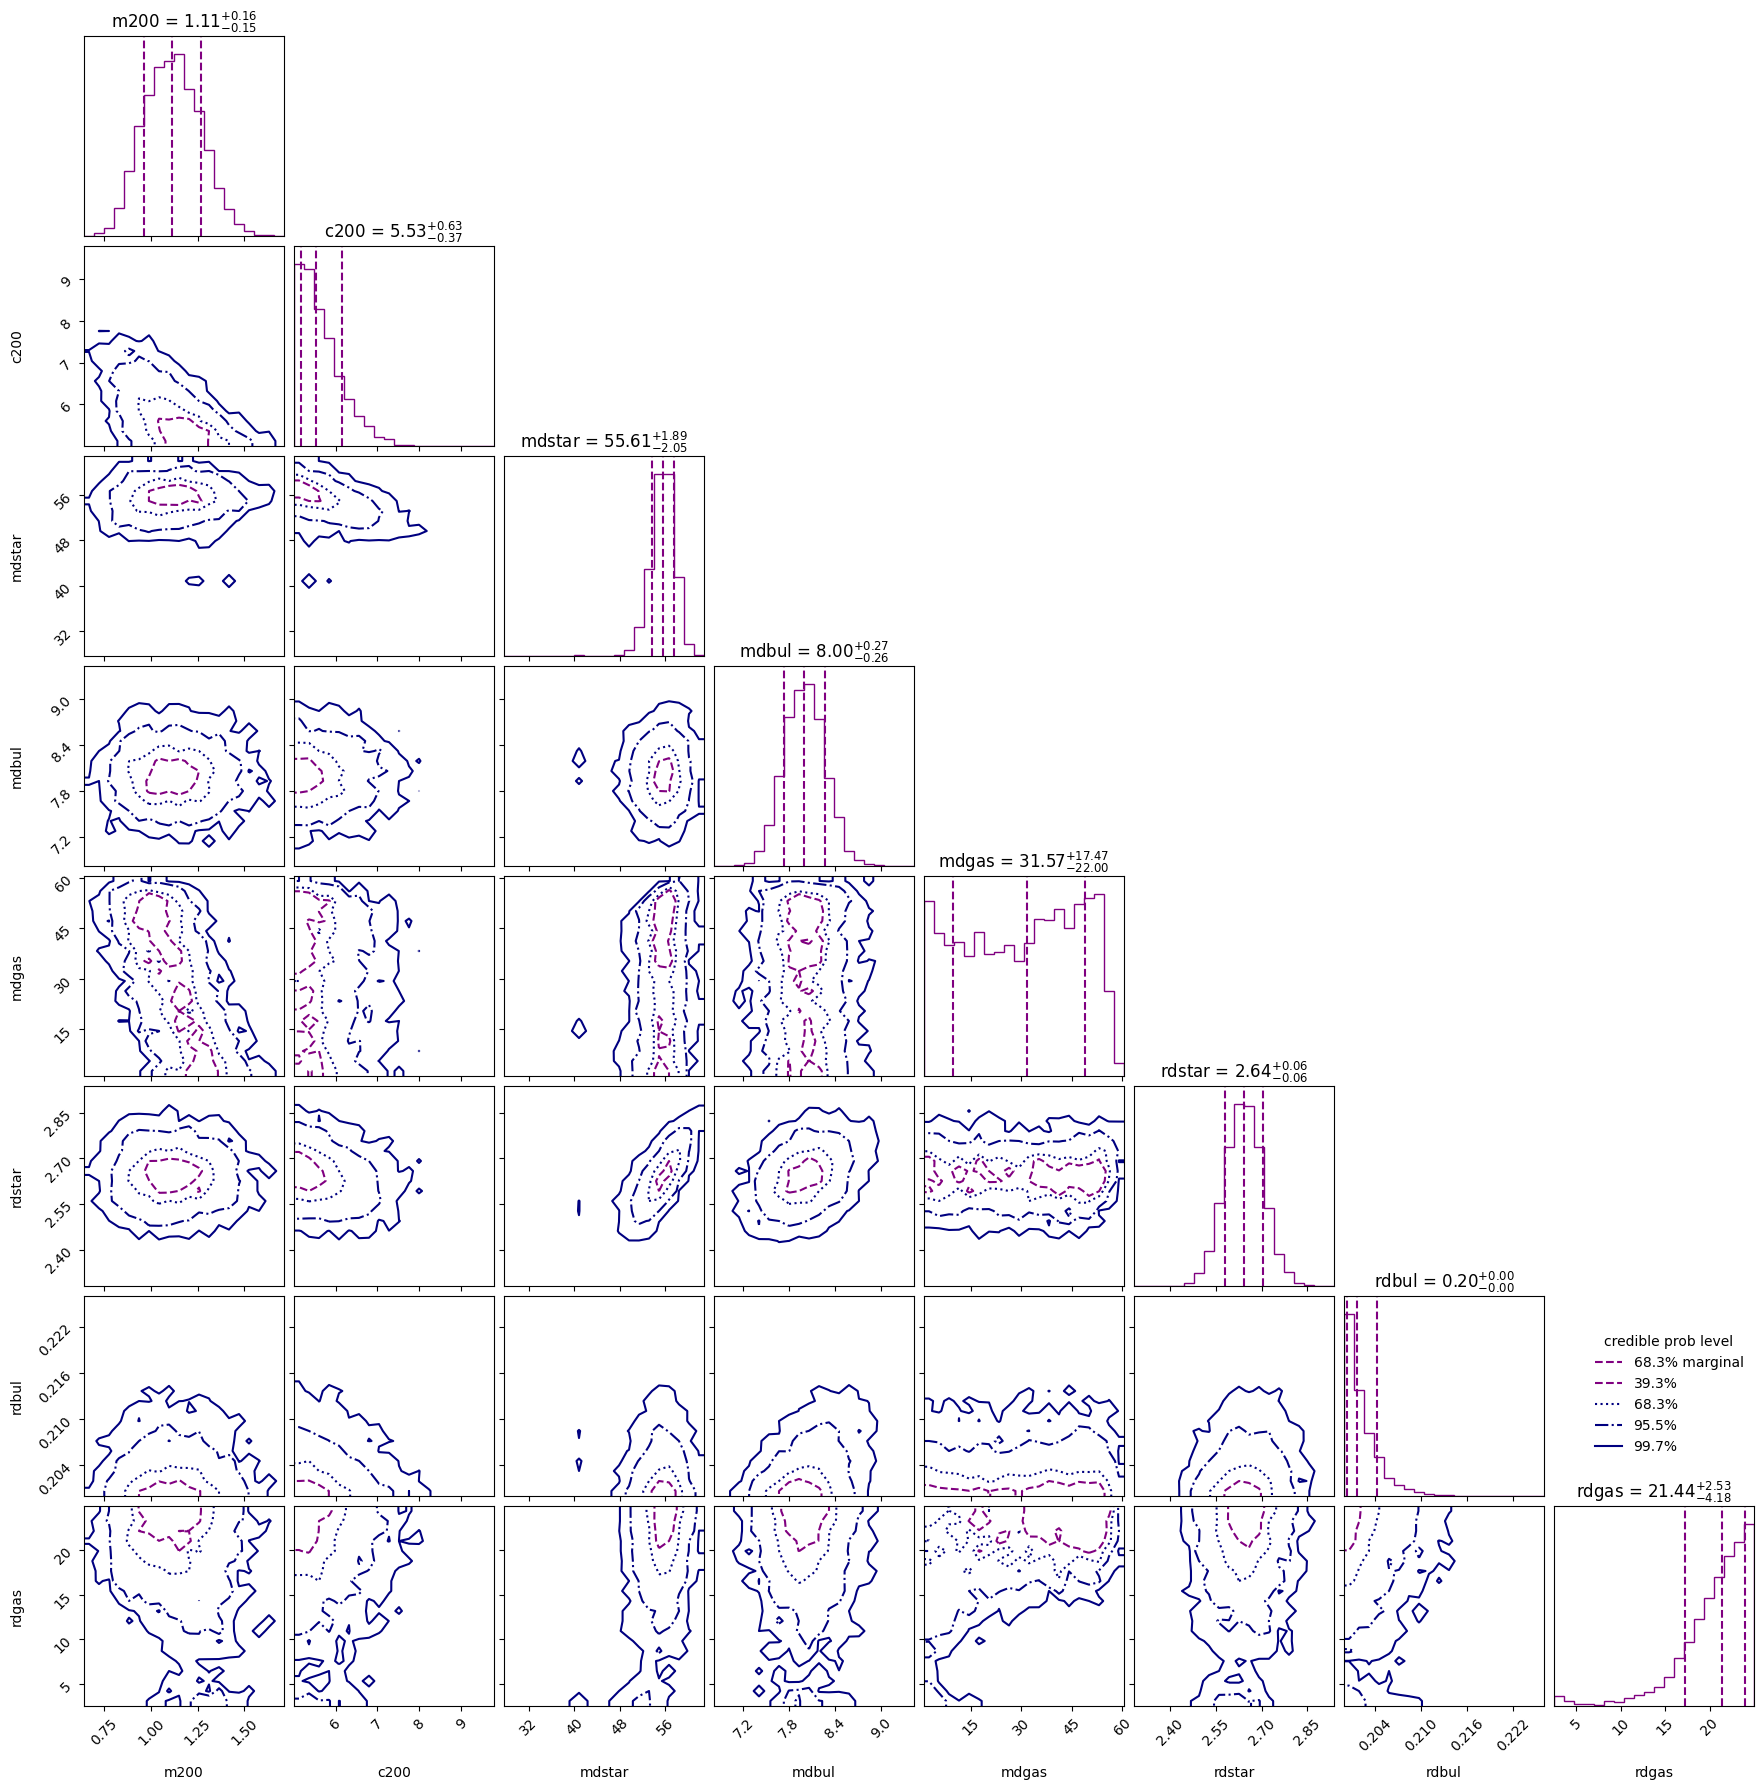

In [27]:
from ultranest.plot import cornerplot
cornerplot(result)
plt.savefig('../../Output/figures/MW/PBfit_corner.png',bbox_inches = 'tight',dpi = 300)

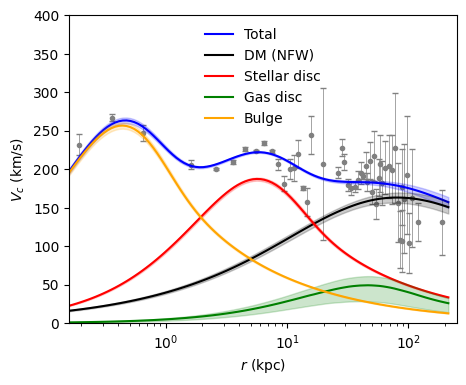

In [11]:
from ultranest.plot import PredictionBand

fig,ax = plt.subplots(figsize = (5,4))
ax.errorbar(mw_r, mw_v, mw_e, fmt = '.', elinewidth = 0.5, capsize = 2, alpha = 1, c = 'grey', zorder = 0)

names = ['Total', 'DM (NFW)', 'Stellar disc', 'Gas disc', 'Bulge']
clrs = ['b', 'k', 'r', 'g', 'orange']

R = np.logspace(-0.8,2.33,100)
bands = [PredictionBand(R) for name in names]

for params in sampler.results['samples']:
    vnames = RCmodel(params,'all',R)
    for i,band in enumerate(bands):
        band.add(vnames[i])

for i,band in enumerate(bands):
    band.line(color = clrs[i], zorder = 1, label = names[i])
    band.shade(color = clrs[i], alpha = 0.2, zorder = 1)

ax.legend(framealpha = 0)
ax.set_xscale('log')
ax.set_xlabel('$r$ (kpc)')
ax.set_ylabel('$V_c$ (km/s)')
ax.set_xlim(10**-0.8,250)
ax.set_ylim(0,400)

plt.savefig('../../Output/figures/MWPBRC_fit.pdf',bbox_inches = 'tight',dpi = 300)

In [28]:
# np.save('../../Output/Ultra/PB_RC_fit/PB_fit_results.npy',sampler.results)

# 3. Compare Exponential vs Plummer profile for the Bulge

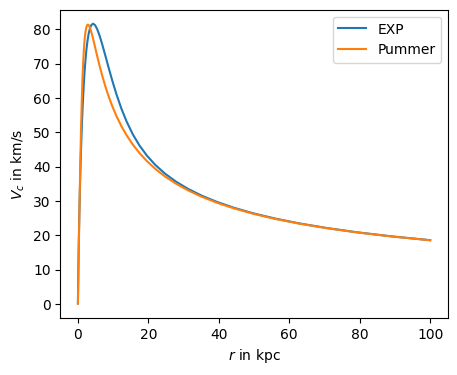

In [170]:
fig,ax = plt.subplots(figsize = (5,4))
r = np.logspace(-3,2, 100)
ax.plot(r, pp.v_exp(np.log10(8)+9,2,r),label = 'EXP')
ax.plot(r, v_plummer(np.log10(8)+9,2,r),label = 'Pummer')
ax.legend()
ax.set_xlabel('$r$ in kpc')
ax.set_ylabel('$V_c$ in km/s');
# ax.text(60,50, 'M = 8 x 1e9 Msun\nb = 2 kpc')
# plt.savefig('../Output/figures/Bulge_comparion.png',bbox_inches = 'tight',dpi = 300)

# 4. Study the LSR dependence of PB14 data

In [82]:
mw = np.loadtxt('../Accessory/mw1.dat')

Rsun,Vsun = 8.5, 220.
indx = np.where(mw[:,0] == Rsun)[0]
r,v = mw[:,2][indx], mw[:,3][indx]

Rsun_new, Vsun_new = 8.3, 244.
indx2 = np.where(mw[:,0] == Rsun_new)[0]
r_, v_ = mw[:,2][indx2], mw[:,3][indx2]

v_new = (Rsun/Rsun_new)*(v - (r_/Rsun)*(Vsun - Vsun_new))
r_new = r_

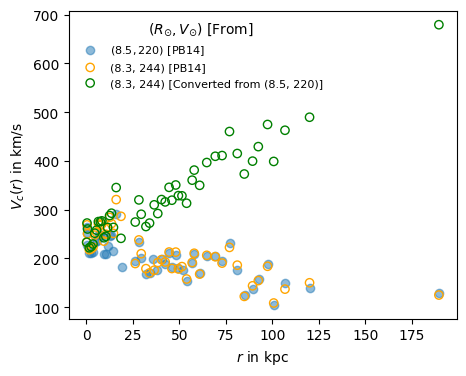

In [81]:
fig,ax = plt.subplots(figsize = (5,4))
ax.scatter(r,v,label = '$(8.5, 220)$ [PB14]',alpha = 0.5)
ax.scatter(r_,v_,facecolor = 'none',edgecolor = 'orange', label = '(8.3, 244) [PB14]')
ax.scatter(r_new, v_new, facecolor = 'none',edgecolor = 'green',label = '(8.3, 244) [Converted from (8.5, 220)]')
ax.legend(title = '$(R_{\odot}, V_{\odot})$ [From]',prop = {'size':8},framealpha = 0)
# ax.set_xlim(0,10)
# ax.text(0.01, 0.9,r'$\tilde{V}_{c}(r) = \frac{R_\odot}{\tilde{R}_\odot} [V_c(r) - \frac{r}{R_\odot}(V_\odot - \tilde{V}_\odot)]$',transform = ax.transAxes)
ax.set_xlabel('$r$ in kpc')
ax.set_ylabel('$V_c(r)$ in km/s')
plt.savefig('../Output/figures/PB_eq9_GC_conversion_2.pdf',bbox_inches = 'tight',dpi = 300)

# 5. Study 2 disc $\rightarrow$ 1 disc approximation

In [11]:
result = np.load('../Output/Ultra/MW_RC_fit/MW_fit_results.npy', allow_pickle = True)[()]
m200,c200,mdstar,mdbul,mdgas,rdstar,rdbul,rdgas = result['posterior']['mean']
r = np.logspace(-1,np.log10(210),len(mw_r))
vdark_2d = pp.v_nfw(np.log10(m200)+12.,pp.rs_nfw(np.log10(m200)+12.,c200),r)
vgas_2d = pp.v_exp(np.log10(mdgas)+9.,rdgas,r)
vbul_2d = pp.v_exp(np.log10(mdbul)+9.,rdbul,r)
vthin_2d = pp.v_exp(np.log10(34.8)+9.,2.53,r)
vthic_2d = pp.v_exp(np.log10(11.2)+9.,3.38,r)
vc_2d = np.sqrt(vdark_2d**2 + vgas_2d**2 + vbul_2d**2 + vthin_2d**2 + vthic_2d**2)
ve_2d = vc_2d*0.05
r_2d = r

In [12]:
def llike_2d(params):
    if params[7] < params[5]:
        return -1e38
    if params[6] > params[5]:
        return -1e38
    if (params[2] < params[3]) or (params[2] < params[4]):
        return -1e38
    vmodel = RCmodel(params,bulge='EXP',r = r_2d)
    indx = np.where((mw_r >= 0))
    ll = -0.5*(((vc_2d[indx] - vmodel[indx])/(ve_2d[indx]))**2).sum()
    ll -= ((np.log10(params[1]) - pp.lc200_SR(np.log10(params[0])+12.0))/0.11)**2
    return ll

In [13]:
ultraroot = '../Output/Ultra/MW_2disc_approximation'
nsteps = 2*len(param_names)
sampler_2d = ultranest.ReactiveNestedSampler(param_names, llike_2d, prior,
                                          log_dir = ultraroot, 
                                          resume = 'resume')
sampler_2d.stepsampler = ultrastep.RegionSliceSampler(nsteps = nsteps)
result_2d = sampler_2d.run()

[ultranest] Resuming from 10892 stored points
[ultranest] Widening roots to 615 live points (have 400 already) ...
[ultranest] Widening roots to 950 live points (have 615 already) ...


[ultranest] Explored until L=-0.2   [-0.9380..-0.9374]*| it/evals=10450/467069 eff=inf% N=400   0    0   
[ultranest] Likelihood function evaluations: 467069
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -21.9 +- 0.1535
[ultranest] Effective samples strategy satisfied (ESS = 2599.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.


----- Thin disc -----
Mdstar = 34.8 x 1e9 Msun
Rdstar = 2.53 kpc

----- Thick disc -----
Mdstar = 11.2 x 1e9 Msun
Rdstar = 3.38 kpc

--- Fit results 1-disc -----
Mdstar = 63.0 x 1e9 Msun
Rdstar = 3.12 kpc

----- DM comparison --------
                   2-disc (Used)    1-disc (fitted)
---------------  ---------------  -----------------
m200 / 1e9 Msun              0.7                0.7
c200                        10.0                9.4


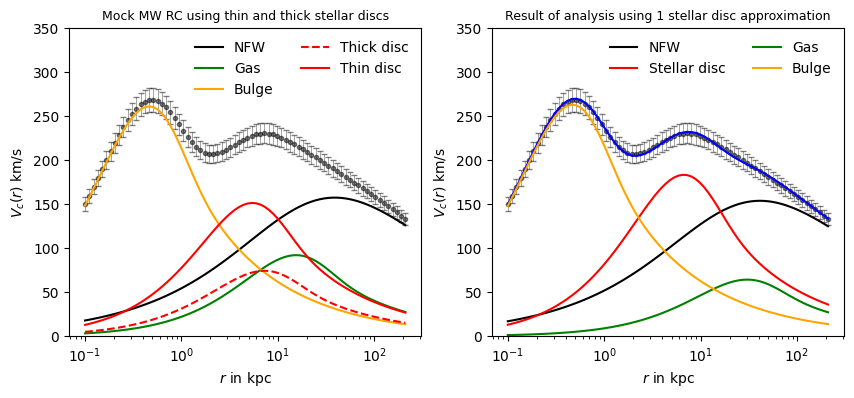

In [86]:
from tabulate import tabulate

params = result['posterior']['mean']
params_2d = result_2d['posterior']['mean']

print ('----- Thin disc -----')
print ('Mdstar = 34.8 x 1e9 Msun')
print ('Rdstar = 2.53 kpc')
print ('\n----- Thick disc -----')
print ('Mdstar = 11.2 x 1e9 Msun')
print ('Rdstar = 3.38 kpc')
print ('\n--- Fit results 1-disc -----')
print (f'Mdstar = {params_2d[2]:.1f} x 1e9 Msun')
print (f'Rdstar = {params_2d[5]:.2f} kpc')
print ('\n----- DM comparison --------')
print (tabulate([[params[0],params_2d[0]],[params[1],params_2d[1]]],
                headers = ['2-disc (Used)','1-disc (fitted)'],
                showindex = ['m200 / 1e9 Msun','c200'],
                floatfmt = ".1f"))

fig,axs = plt.subplots(1,2,figsize = (10,4))
ax1,ax2 = axs
for ax in axs:
    ax.errorbar(r_2d, vc_2d, ve_2d, color = 'k', fmt = '.', capsize = 2, elinewidth = 0.5,alpha = 0.5,zorder = 0)
    ax.set_xscale('log')
    ax.set_ylim(0,350)
    ax.set_xlabel('$r$ in kpc')
    ax.set_ylabel('$V_c(r)$ km/s')

ax1.plot(r_2d,vdark_2d,c = 'k',label = 'NFW')
ax1.plot(r_2d,vgas_2d,c = 'g',label = 'Gas')
ax1.plot(r_2d,vbul_2d,c = 'orange',label = 'Bulge')
ax1.plot(r_2d,vthic_2d,c = 'r',ls = '--',label = 'Thick disc')
ax1.plot(r_2d,vthin_2d,c = 'r',ls = '-',label = 'Thin disc')
ax1.legend(framealpha = 0,loc = 'upper right',ncol = 2)
ax1.set_title('Mock MW RC using thin and thick stellar discs',size = 9)

vmodel,vnfw,vstar,vgas,vbul = RCmodel(params_2d,r = r_2d, output = 'all')
ax2.plot(r_2d,vmodel,c = 'b',zorder = 1)
ax2.plot(r_2d,vnfw,c = 'k',label = 'NFW')
ax2.plot(r_2d,vstar,c = 'r',label = 'Stellar disc')
ax2.plot(r_2d,vgas,c = 'g',label = 'Gas')
ax2.plot(r_2d,vbul,c = 'orange',label = 'Bulge')
ax2.legend(framealpha = 0,ncol = 2)
ax2.set_title('Result of analysis using 1 stellar disc approximation',size = 9);
plt.savefig('../Output/figures/MW_2disc_approximation.png',bbox_inches = 'tight',dpi = 300)

# 6. Obain VDF of MW at $R_\odot$ (gal frame and Earth frame)

In [30]:
MW_dict['vdf_RCfit'].keys()

dict_keys(['v', 'vdfs', 'vdf_16', 'vdf_50', 'vdf_84', 'vdfE_16', 'vdfE_50', 'vdfE_84', 'vE', 'vdfEs', 'vescs', 'vcircs', 'vescRs', 'rhosuns', 'full_pdfs', 'full_samp', 'full_indxs', 'full_sampN', 'par_pdfs', 'par_samp', 'par_indxs', 'par_sampN'])

In [9]:
# DONT RUN - DATA ALREADY SAVED
import math, sys
from scipy.signal import medfilt
from tqdm.notebook import tqdm
sys.path.append('../../')
from project.recoil import get_vdf_ert, norm
from project.energetics import EI_vdf as EI
import project.profiles as pp

samproot = '../../Output/Ultra/PB_RC_fit/PB_fit_results.npy'
data = np.load(samproot,allow_pickle = True)[()]
samp = data['samples']
sampN = len(samp[:,0])
stepN = math.floor(float(sampN)/1000.)
if stepN < 1: stepN = 1

vdfs = []
vescs = []
vcircs = []
vdfEs = []
vescEs = []
rhosuns = []
v = np.linspace(1e-5, 700, 300)
vE = np.linspace(1e-5, 900, 300)
Rsun = 8.0
for i in tqdm(range(0, sampN, stepN)):
    params = samp[i]
    m200,c200,mdstar,mdbul,mdgas,rdstar,rdbul,rdgas = params
    rs = pp.rs_nfw(np.log10(m200)+12., c200)
    rhosuns.append(pp.density_nfw(np.log10(m200)+12.,rs, Rsun))
    
    model = {'dm':['NFW',np.log10(m200)+12.,rs]}
    model['disk'] = ['EXP',np.log10(mdstar)+9.,rdstar]
    model['gas'] = ['EXP',np.log10(mdgas)+9.,rdgas]
    model['bulge'] = ['EXP',np.log10(mdbul)+9.,rdbul]

    ei = EI(model)
    vesc = ei.Vmax(Rsun)
    vescs.append(vesc)

    ei_vdf = ei.get_vdf(Rsun, n = 50)
    v_, vdf_ = ei_vdf[:,0], ei_vdf[:,1]
    vdf_ = medfilt(vdf_, kernel_size = 3)
    vdf = sp.interpolate.interp1d(v_, vdf_, 
                                  kind = 'cubic',
                                  fill_value = 0,
                                  bounds_error = False)(v)
    vdfs.append(vdf)

    vdark = pp.v_nfw(np.log10(m200)+12., rs, Rsun)
    vdstar = pp.v_exp(np.log10(mdstar)+9., rdstar, Rsun)
    vdgas = pp.v_exp(np.log10(mdgas)+9., rdgas, Rsun)
    vdbul = pp.v_exp(np.log10(mdbul)+9., rdbul, Rsun)
    vcirc = np.sqrt(vdark**2 + vdgas**2 + vdstar**2 + vdbul**2)
    vcircs.append(vcirc)

    vdfE = get_vdf_ert(vE, v_, vdf_, vesc, vcirc)
    vdfEs.append(vdfE)

    indx = np.where((vdfE < 1e-5) & (vE > 300))[0]
    if np.any(indx):
        vescEs.append(vE[indx][0])
    else:
        vescEs.append(vE[-1])

vdfs = np.array(vdfs)
nan_mask = np.isnan(vdfs).any(axis=1)
vdfs = vdfs[~nan_mask]
vescs = np.array(vescs)[~nan_mask]
vcircs = np.array(vcircs)[~nan_mask]
vdfEs = np.array(vdfEs)[~nan_mask]
vescEs = np.array(vescEs)[~nan_mask]
rhosuns = np.array(rhosuns)[~nan_mask]/pc.GeV_by_cc

MW_dict['vdf_PBRCfit'] = {}
RC = MW_dict['vdf_PBRCfit']

RC['v'], RC['vdfs'] = v, vdfs
RC['vdf_16'], RC['vdf_50'], RC['vdf_84'] = np.percentile(vdfs, [16, 50, 84], axis = 0)
RC['vdfE_16'], RC['vdfE_50'], RC['vdfE_84'] = np.percentile(vdfEs, [16, 50, 84], axis = 0)
RC['vE'], RC['vdfEs'] = vE, vdfEs
RC['vescs'], RC['vcircs'] = vescs, vcircs
RC['vescRs'] = vescEs
RC['rhosuns'] = rhosuns


pickle.dump(MW_dict, open('../../Output/MW_dict.pkl','wb'))

  0%|          | 0/1073 [00:00<?, ?it/s]

In [143]:
MW_dict = pickle.load(open('../Output/MW_dict.pkl','rb'))
RC = MW_dict['vdf_RCfit']

def plot_MW_vdfs(ax = None):
    if not ax:
        fig,ax = plt.subplots(figsize = (5,4))
    for i in range(len(RC['vdfs'])):
        ax.plot(RC['v'], RC['vdfs'][i], c = 'k', alpha = 0.2, lw = 0.2)
    ax.plot('v', 'vdf_50', data = RC, c = 'r', lw = 0.8, zorder = 2)
    ax.fill_between('v', 'vdf_16', 'vdf_84', data = RC, color = 'g', alpha = 0.4)
    vesc_16, vesc_50, vesc_84 = np.percentile(vescs, [16, 50, 84])
    ax.fill_betweenx([-1e-4, 0.5e-3], vesc_16, vesc_84, color = 'g', alpha = 0.5)
    ax.plot([vesc_50]*2, [-1e-4, 0.5e-3], c = 'r')
    ax.set_xlim(0,530)

def plot_MW_vdfEs(ax = None):
    if not ax:
        fig,ax = plt.subplots(figsize = (5,4))
    for i in range(len(RC['vdfEs'])):
        ax.plot(RC['vE'], RC['vdfEs'][i], c = 'k', alpha = 0.1, lw = 0.1)
    ax.plot('vE', 'vdfE_50', data = RC, c = 'r', lw = 0.8, zorder = 2)
    ax.fill_between('vE', 'vdfE_16', 'vdfE_84', data = RC, color = 'g', alpha = 0.4)
    ax.set_xlim(0,800)

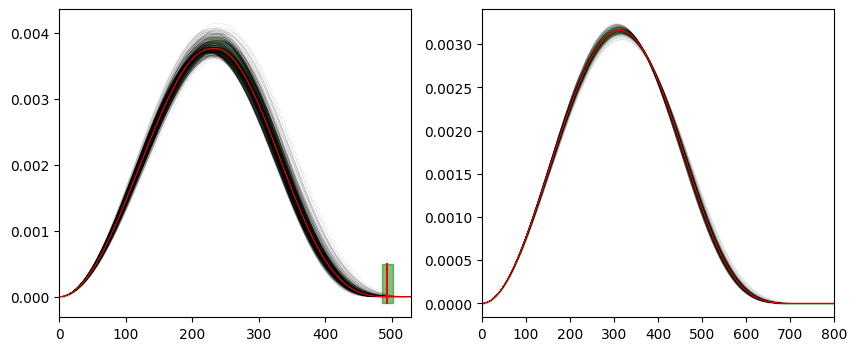

In [144]:
fig,axs = plt.subplots(1,2,figsize = (10,4))
ax1,ax2 = axs

plot_MW_vdfs(ax1)
plot_MW_vdfEs(ax2)